In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq.job import job_monitor
provider = IBMQ.load_account()

/tmp/ipykernel_2458/1933496013.py:11: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


# グローバーのアルゴリズムで簡単なパズルを解く
どうにか実際にアルゴリズムを使えないかと思い、簡単なパズルを解くことにしました。
パズルの名前は存在しないようですが、以下のような感じで、「ボタンを押すと両隣のボタンも含めて点滅が入れ替わる」というルールで、全てのボタンを光らせることが目標です。

3×3にボタンが配置されている場合。右上のボタンを押す前後で以下のように変化する。


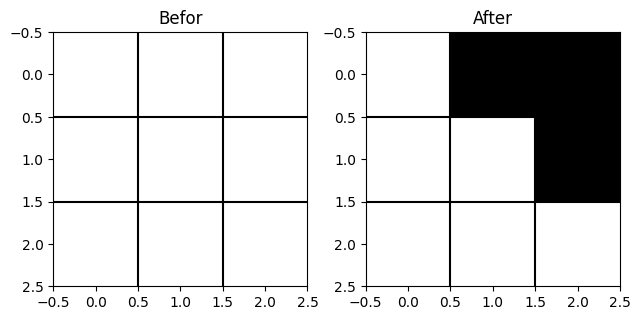

In [2]:
board1 = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]
])

board2 = np.array([
    [0, 1, 1],
    [0, 0, 1],
    [0, 0, 0]
])

boards = [board1, board2]
names = ['Befor', 'After']

fig, axs = plt.subplots(1, len(boards))

for ax, board, name in zip(axs, boards, names):
    ax.imshow(board, cmap='binary', interpolation='none')
    ax.set_title(name)

    for i in range(board.shape[0] - 1):
        ax.axhline(y=i + 0.5, color='black')
    for j in range(board.shape[1] - 1):
        ax.axvline(x=j + 0.5, color='black')

plt.tight_layout()
print("3×3にボタンが配置されている場合。右上のボタンを押す前後で以下のように変化する。")
plt.show()


オラクルの考え方にかなり戸惑いましたが、 <br>
「定められた操作や、制約条件に基づく状態変化が数式化できる」 <br>
かつ <br>
「各状態に『正解』か『不正解』を一意に割り振ることができる」 <br>
ような状態とビットの対応がうまくいけば、操作や条件を再現するゲートは（対応がうまくいった時点で）作成可能だし、正誤判断は複数制御ZゲートとNotゲートで実装できました。 <br>
同系統の問題であれば制約条件の違いによる難易度差が生まれないのが面白いです。

# 実装方法

今回の問題設定の場合は、各ボタンが光っているかどうかを9つの量子ビットの0 or 1 に対応付けすれば、考え方がシンプルで、正解の判定も容易なので、それを採用しました。<br> ボタンに対するビットの割り振りは、ボタンを押す操作を回路で表現するときに書きやすいように、真ん中を0にして、左端から反時計回りに1〜8を振るようにしました。

In [3]:
board = [['1', '8', '7'],
         ['2', '0', '6'],
         ['3', '4', '5']]

print('量子ビットの割り振り:')

for row in board:
    print('|', end=' ')
    for panel in row:
        print(panel, end=' | ')
    print()


量子ビットの割り振り:
| 1 | 8 | 7 | 
| 2 | 0 | 6 | 
| 3 | 4 | 5 | 


次に、<br>
各ボタンを押す->複数のボタンの点滅が入れ替わる<br>
という操作に対応する回路を作る必要があります。ところが、判定に用いるビットに操作をすると、元の入力状態にも影響が出るので、入力と出力の対応付けが単純ではなくなってしまいます。<br>
今回は、入力状態を記憶する用に量子ビットを9bit追加して対処しました。<br>
こうすることで、ボタンの操作は単純にCNOTゲートで表現できます。ボタン操作と入力保持を関数にしておきます。

In [4]:
 # ボタンの情報を記憶する回路        
def memorize(qc):
    for i in range(0,n):
        qc.cx(i,i+n)
        

#ボタンを押すと隣も入れ替わる
def push_button(qc, i):
    if i == 0:
        qc.cx(9, 2)
        qc.cx(9, 4)
        qc.cx(9, 6)
        qc.cx(9, 8)
    elif i == 1:
        qc.cx(10, 8)
        qc.cx(10, 2)
    elif i == 8:
        qc.cx(17, 7)
        qc.cx(17, 0)
        qc.cx(17, 1)
    elif i % 2 == 0:
        qc.cx(i+9, i-1)
        qc.cx(i+9, 0)
        qc.cx(i+9, i+1)
    else:
        qc.cx(i+9, i-1)
        qc.cx(i+9, i+1)
        

正解の状態のみ位相を反転する回路は、Multi-controlled Zゲートが実装できれば、Xゲートと組み合わせて任意の状態に対して実装できます。<br>
Multi-controlled Zゲートは、Multi-controlled Toffoli(MCT)ゲートをHゲートで挟めば実装できるので、問題はMCTゲートです。これはqiskitにあったので、ありがたく使わせてもらいました。<br>
振幅を増幅する回路も関数にしておきます。こちらもMCTゲートを使えば簡単に実装できます。

In [5]:
#全ボタンが光っている時のみ位相を反転する
def is_correct(qc):
    qc.h(8)
    qc.mct(list(range(8)),8)
    qc.h(8)
    

#正解の振幅を増幅する回路
def make_diffuser(qc, n):
    qc.barrier()
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.mct(list(range(n-1)),n-1)
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    

これらを元に回路を生成します。

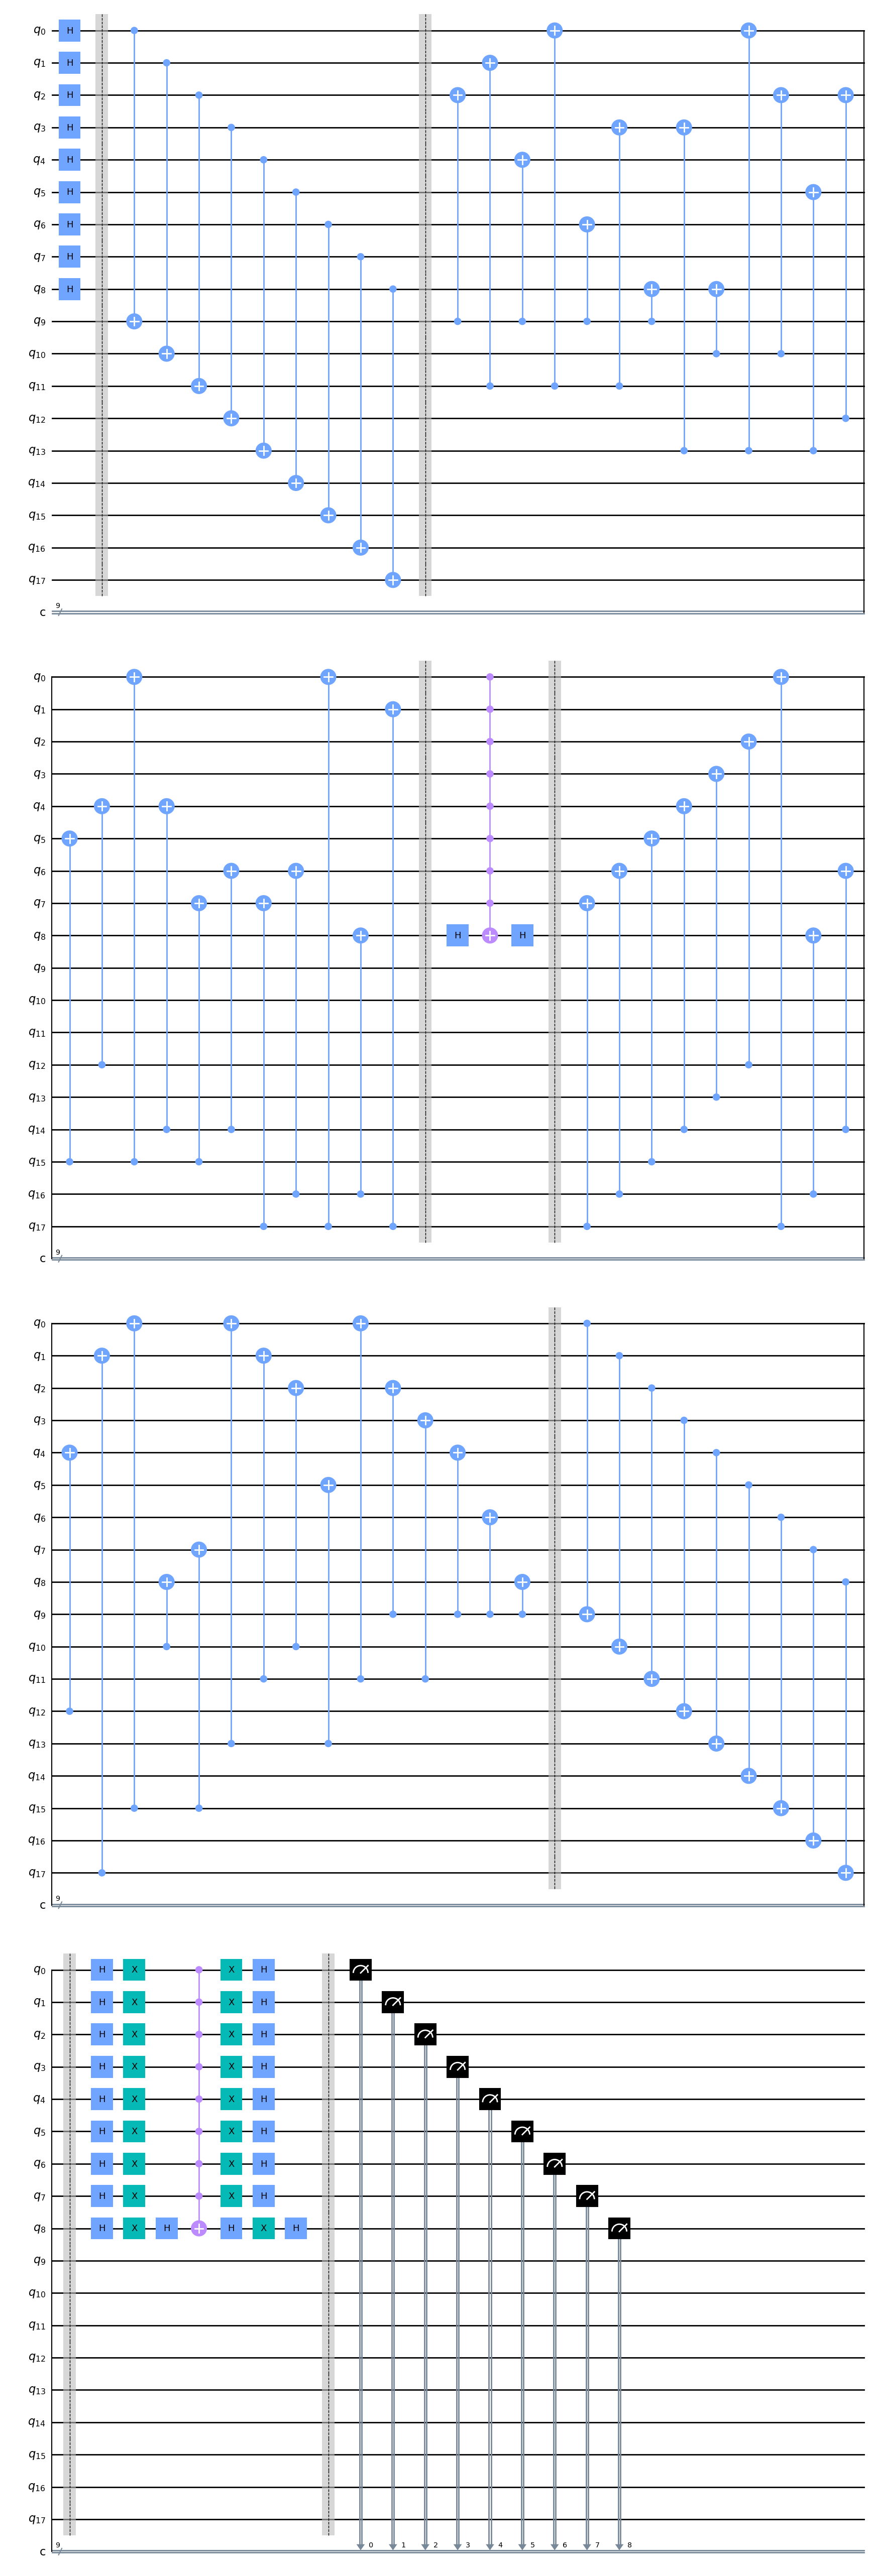

In [6]:
#量子ビット数と古典ビット数
n = 9 #ボタンの数
q = 2 * n #量子ビット数. 2倍なのはボタン操作用に記録するビットがそれぞれあるから
c = 9 #古典ビット数

        
    
#最初に全ての状態を同じ確率で重ね合わせる
circ_init = QuantumCircuit(q, c)
circ_init.h(range(n))



#オラクル回路
oracle = QuantumCircuit(q, c)
oracle.barrier()

#入力状態を記憶
memorize(oracle)

oracle.barrier()

#各ボタンの操作を重ねる
for i in range(0, n):
    push_button(oracle, i)

oracle.barrier()

#正解しているものだけ位相を反転させる
is_correct(oracle)

oracle.barrier()

#逆操作でボタンの状態を元に戻す
for i in range(0, n):
    push_button(oracle, n-i-1)
oracle.barrier()

memorize(oracle)


#位相回路
diffuser = QuantumCircuit(q, c)
make_diffuser(diffuser, n)


#繋げてグローバーの繰り返し回路を作る
circ_g = oracle.compose(diffuser)

#測定回路
meas = QuantumCircuit(q, c)
meas.barrier()
meas.measure(range(n),range(n))


#n回繰り返した回路を出力する
def repeated_circuit(n):
    circ = circ_init
    for i in range(0,n):
        circ = circ.compose(circ_g)
    circ = circ.compose(meas)
    return circ


#回路を表示
repeated_circuit(1).draw(output='mpl')

シミュレーターで試します。繰り返し回数nは、<br>
解が1個の場合、n = 17<br>
解が2個の場合、n = 8<br>
解が3個の場合、n = 5 ...<br>
のとき確率が大きくなります。シミュレータの場合、nがそれほど大きくなくても差が目に見えて分かりますね。<br>
結果の表示は、単純に値が大きいものからソートして、上位10組だけ表示するようにしました。

In [8]:
#シミュレータで試す
simulator = Aer.get_backend('qasm_simulator')

shots = 8192 
n = 17 #繰り返し回数

job_sim = execute(repeated_circuit(n), backend=simulator, shots=shots)

#実行結果からカウントのみ取得
counts_sim = job_sim.result().get_counts(repeated_circuit(n))

#得られた辞書データを大きい順にソート
sorted_counts_sim = sorted(counts_sim.items(), key=lambda x: x[1], reverse=True)[:10]
print(sorted_counts_sim)

[('010101011', 8181), ('000110110', 1), ('100000001', 1), ('000001000', 1), ('101111110', 1), ('001110011', 1), ('111111010', 1), ('100101100', 1), ('011000000', 1), ('111101110', 1)]


In [26]:
#プロバイダーの設定
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider(instance='ibm-q-utokyo/internal/adv-sci-1a-2023s')

back=provider.backends()

for i in back:
    print(i)

<IBMBackend('ibmq_kolkata')>
<IBMBackend('simulator_stabilizer')>
<IBMBackend('ibm_sherbrooke')>
<IBMBackend('ibmq_guadalupe')>
<IBMBackend('ibmq_manila')>
<IBMBackend('ibmq_quito')>
<IBMBackend('simulator_mps')>
<IBMBackend('ibm_kawasaki')>
<IBMBackend('ibm_lagos')>
<IBMBackend('ibm_nairobi')>
<IBMBackend('ibm_hanoi')>
<IBMBackend('ibmq_lima')>
<IBMBackend('ibmq_mumbai')>
<IBMBackend('simulator_statevector')>
<IBMBackend('ibm_algiers')>
<IBMBackend('ibm_auckland')>
<IBMBackend('ibm_brisbane')>
<IBMBackend('ibm_cairo')>
<IBMBackend('ibmq_qasm_simulator')>
<IBMBackend('simulator_extended_stabilizer')>
<IBMBackend('ibm_nazca')>
<IBMBackend('ibm_perth')>
<IBMBackend('ibmq_belem')>
<IBMBackend('ibmq_jakarta')>


In [32]:
#デバイスを取得
device=back[7]

shots = 2048
n = 6

#回路を実行、測定結果を取得して配列に
job_exp = execute(repeated_circuit(n), backend = device, shots=shots)
job_monitor(job_exp)


Traceback (most recent call last):
  Cell In[32], line 8
    job_exp = execute(repeated_circuit(n), backend = device, shots=shots)
  File /opt/conda/lib/python3.10/site-packages/qiskit/utils/deprecation.py:182 in wrapper
    return func(*args, **kwargs)
  File /opt/conda/lib/python3.10/site-packages/qiskit/utils/deprecation.py:182 in wrapper
    return func(*args, **kwargs)
  File /opt/conda/lib/python3.10/site-packages/qiskit/execute_function.py:302 in execute
    experiments = transpile(
  File /opt/conda/lib/python3.10/site-packages/qiskit/compiler/transpiler.py:358 in transpile
    _check_circuits_coupling_map(circuits, cmap_conf, backend)
  File /opt/conda/lib/python3.10/site-packages/qiskit/compiler/transpiler.py:417 in _check_circuits_coupling_map
    raise TranspilerError(
TranspilerError: 'Number of qubits (18) in circuit-129 is greater than maximum (7) in the coupling_map'

Use %tb to get the full traceback.


In [ ]:
job_monitor(job_exp)

In [ ]:
counts_exp = job_exp.result().get_counts(repeated_circuit(i))

#得られた辞書データを大きい順にソート
sorted_counts_exp = sorted(counts_exp.items(), key=lambda x: x[1], reverse=True)[:10]
print(sorted_counts_exp)